# devlog 2024-01-08

_author: Tyler Coles_

Just to recap functional parameters (and to test new AST manipulation happening behind the scenes), let's reimplement the Bonus Example from the 2023-10-10 notebook / presentation (or nearly the same example, anyway) now that we have first-class support for this feature.

First I'll set up a simulation template function (using an SIRS IPM, the Pei GEO, and the Pei commuting model) which allows us to vary only beta, then we'll implement a time-and-node-varying beta function and execute it twice -- once specified as a Python callable from this Notebook, and once specified as text to mimic input from a toml file. We should see the same result for each.

In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

from epymorph import *
from epymorph.initializer import single_location
from epymorph.params import ParamValue

# This function sets up a basic simulation, runs it, and plots the results,
# allowing us to vary only the beta parameter.


def run_and_plot(beta: ParamValue) -> None:
    sim = StandardSimulation(
        ipm=ipm_library["sirs"](),
        mm=mm_library["pei"](),
        geo=geo_library["pei"](),
        params={
            # IPM params
            "beta": beta,
            "gamma": 1 / 6,
            "xi": 1 / 90,
            # MM params
            "theta": 0.1,
            "move_control": 0.9,
        },
        time_frame=TimeFrame.of("2015-01-01", 150),
        initializer=partial(single_location, location=0, seed_size=10_000),
    )

    with sim_messaging(sim):
        out = sim.run()

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
    x_axis = np.arange(out.dim.days)
    ax1.set(title="New infections", ylabel="infections")
    ax1.plot(x_axis, out.incidence_per_day[:, :, 0], label=out.geo_labels)
    ax1.legend()

    # For the sake of graphing beta, I can fetch it in its fully-evaluated form
    # from the sim object.
    ax2.set(title="beta function", ylabel="beta", xlabel="days")
    ax2.plot(x_axis, sim.params["beta"], label=out.geo_labels)
    ax2.legend()

    fig.tight_layout()
    plt.show()

I've contrived this beta function so as to have a sharp drop-off after 50 simulation days, where each node's drop is offset by a few days. Perhaps not very realistic, but it could demonstrate the sudden implementation of (very effective) disease mitigations in the different US states. The assumed effectiveness of those mitigations is further varied by arbitrarily dividing states by population (under and over 9 million). This lets us demonstrate access to the GEO when calculating parameter values.

In any case, we see that the typical disease curves take a sharp dive as soon as beta drops off in that state.

Running simulation (StandardSimulation):
• 2015-01-01 to 2015-05-31 (150 days)
• 6 geo nodes
|####################| 100% 
Runtime: 0.271s


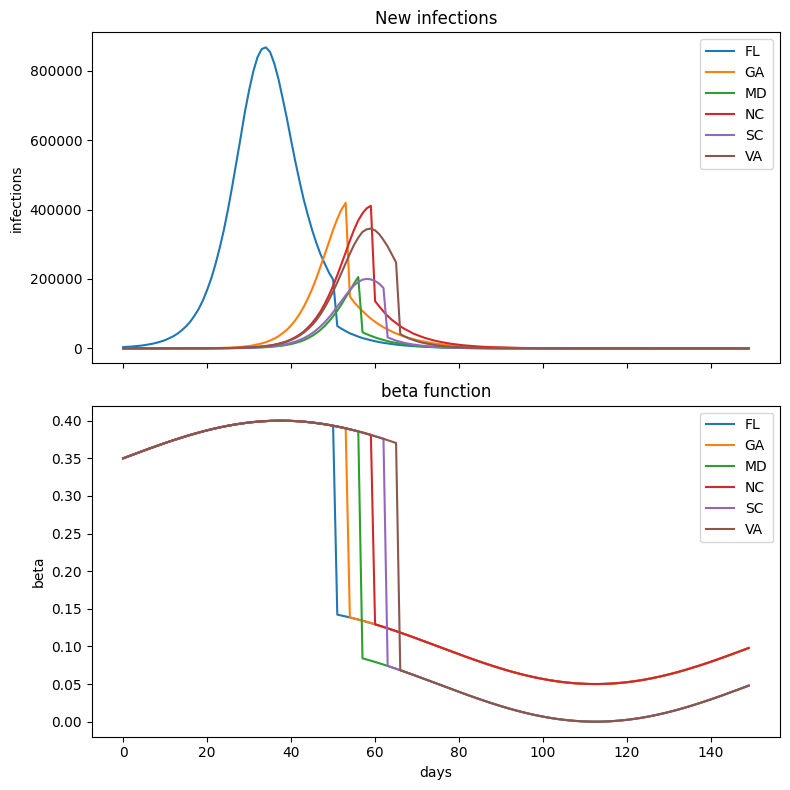

In [2]:
# Here I define beta as a function via Python callable.
# References to 'geo' and 'dim' use the proxy from the above `import *`
# Proxies are replaced with true objects for evaluation.


def beta_fn(t, n):
    x = 0.35 + 0.05 * np.sin(2 * np.pi * (t / dim.days))
    cutoff = 50 + (n * 3)
    if t > cutoff:
        pop = geo["population"][n]
        cut = 0.3 if pop < 9_000_000 else 0.25
        x -= cut
    return x


# The function is our beta value!
run_and_plot(beta_fn)

Running simulation (StandardSimulation):
• 2015-01-01 to 2015-05-31 (150 days)
• 6 geo nodes
|####################| 100% 
Runtime: 0.271s


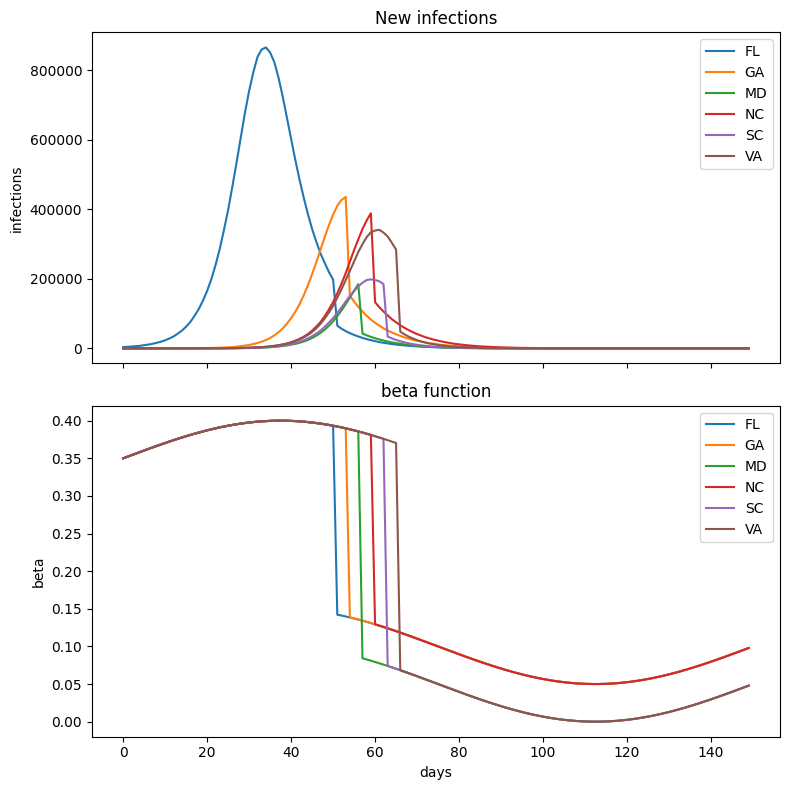

In [3]:
# I can also define beta as text which defines a Python function.
# Notice this function definition is exactly the same as the code in the previous example.
# The outcome is the same, this is just a different way to provide the input
# (which is useful, e.g., for running simulations from a toml file).

beta_fn_txt = """\
def beta_fn(t, n):
    x = 0.35 + 0.05 * np.sin(2 * np.pi * (t / dim.days))
    cutoff = 50 + (n * 3)
    if t > cutoff:
        pop = geo['population'][n]
        cut = 0.3 if pop < 9_000_000 else 0.25
        x -= cut
    return x
"""

run_and_plot(beta_fn_txt)